In [1]:
#importing libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_gen import *
from predict_info import *

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [2]:
X, y, df = data_gen(N_data=50000)
# N_data=100000,N_tu=256,x0=(64, 196),w=(5,15),A=(1,20),bkg=(1,15)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Autoencoder

In [4]:
# ENCODER

input_sig = Input(shape=(256,1)) 
norm = Normalization()(input_sig)

x = Conv1D(64,3, activation='relu', padding='same')(norm) 
x1 = MaxPooling1D(16, padding = 'same')(x) 
x2 = Conv1D(16,3, activation='relu', padding='same')(x1) 


flat = Flatten()(x2) 
encoded = Dense(16,activation = 'relu')(flat) 
 
print("shape of encoded {}".format(np.shape(encoded))) 
 
# DECODER  
 
dence = Dense(16,activation = 'relu')(encoded)
resh = Reshape((16,1))(dence)
x2_ = Conv1D(16, 3, activation='relu', padding='same')(resh) 
x1_ = UpSampling1D(16)(x2_) 
x_ = Conv1D(64, 3, activation='relu', padding='same')(x1_) 
flat = Flatten()(x_) 
decoded = Dense(256,activation = 'relu')(flat) 
decoded = Reshape((256,1))(decoded) 



autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
             loss='mean_squared_error')

callback_conv = [EarlyStopping(monitor='val_loss', patience=5),
                TensorBoard(log_dir = "./logs/auto/{}-{}-{}-{}".format(datetime.datetime.today().month,
                                                                      datetime.datetime.today().day,
                                                                      datetime.datetime.today().hour,
                                                                      datetime.datetime.today().minute), update_freq="epoch")
]
autoencoder.summary()



shape of encoded (None, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 1)]          0         
                                                                 
 normalization (Normalizatio  (None, 256, 1)           3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 256, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            3088      
                                                                 
 flatten (Flatten)           (Non

Epoch 1/100
586/586 [==============================] - 26s 42ms/step - loss: 34.2017 - val_loss: 30.6459
Epoch 2/100
586/586 [==============================] - 24s 41ms/step - loss: 28.1192 - val_loss: 27.2988
Epoch 3/100
586/586 [==============================] - 23s 40ms/step - loss: 26.4004 - val_loss: 24.9165
Epoch 4/100
586/586 [==============================] - 23s 40ms/step - loss: 22.9589 - val_loss: 21.0799
Epoch 5/100
586/586 [==============================] - 23s 40ms/step - loss: 19.4731 - val_loss: 18.6674
Epoch 6/100
586/586 [==============================] - 24s 41ms/step - loss: 18.2732 - val_loss: 18.1640
Epoch 7/100
586/586 [==============================] - 24s 41ms/step - loss: 17.7611 - val_loss: 17.7956
Epoch 8/100
586/586 [==============================] - 23s 40ms/step - loss: 17.2339 - val_loss: 17.1545
Epoch 9/100
586/586 [==============================] - 24s 41ms/step - loss: 16.3994 - val_loss: 15.6553
Epoch 10/100
586/586 [==============================] -

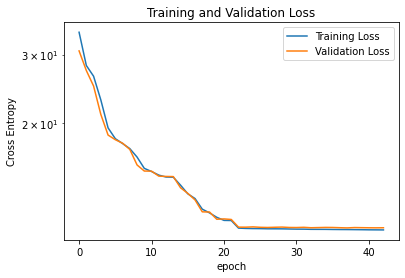

In [5]:
history = autoencoder.fit(X_train, X_train,
          validation_data = (X_test, X_test),
          batch_size=64, epochs=100, callbacks=[callback_conv])


loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

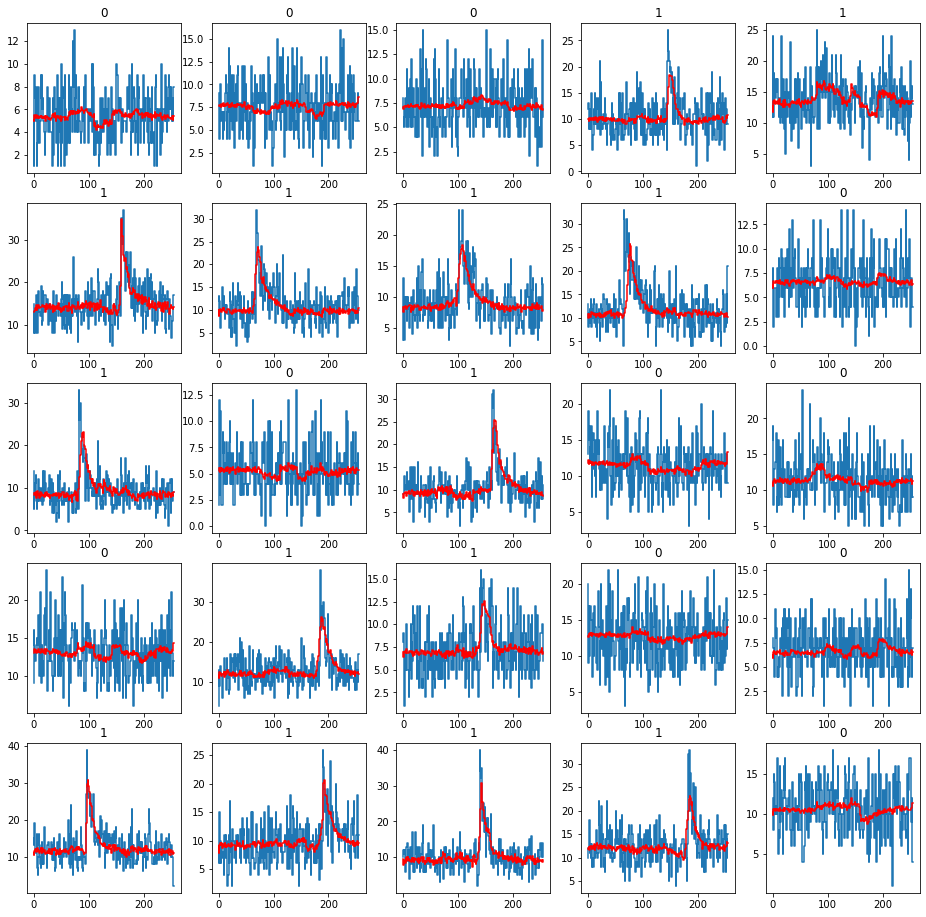

In [6]:
X_pred = autoencoder.predict(X_test)
x = np.arange(256)
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].set_title(y_test[ind])
        axs[i,j].step(x,X_test[ind])
        axs[i,j].step(x,X_pred[ind],color="red");

In [8]:
#autoencoder.save("autoencoder_conv1d")

INFO:tensorflow:Assets written to: autoencoder_conv1d\assets
